##  Load Packages

In [1]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains

## Load Data

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat"
hibbs = CSV.File(HTTP.get(data).body, delim=" ") |> DataFrame
first(hibbs, 6)

,year,growth,vote,inc_party_candidate,other_candidate
,Int64,Float64,Float64,String,String
1,1952,2.4,44.6,Stevenson,Eisenhower
2,1956,2.89,57.76,Eisenhower,Stevenson
3,1960,0.85,49.91,Nixon,Kennedy
4,1964,4.21,61.34,Johnson,Goldwater
5,1968,3.02,49.6,Humphrey,Nixon
6,1972,3.62,61.79,Nixon,McGovern


## Graphing the bread and peace model

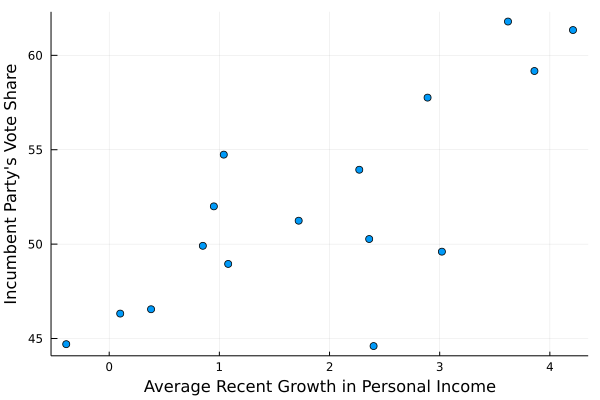

In [3]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="Average Recent Growth in Personal Income",
    ylabel="Incumbent Party's Vote Share",
    legend=false
)

## Linear Regression

In [4]:
@model function m1(g, v)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    
    μ = α .+ g * β
    v ~ MvNormal(μ, sqrt(σ))
end;

In [5]:
model = m1(hibbs[:, :growth], hibbs[:, :vote])
chain = sample(model, NUTS(0.65), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\rHLGJ\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = α, β, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           α   44.6958    2.0636     0.0653    0.0936   337.8183    0.9997
           β    3.6036    0.8403     0.0266    0.0398   354.6537    0.9990
           σ   21.0085   10.7222     0.3391    0.5419   402.3635    1.0038

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           α   40.2623   43.5166   44.8644   46.1093   48.1404
           β    2.007

In [6]:
results = get(chain, [:α, :β, :σ]);

## Plot Regression Line

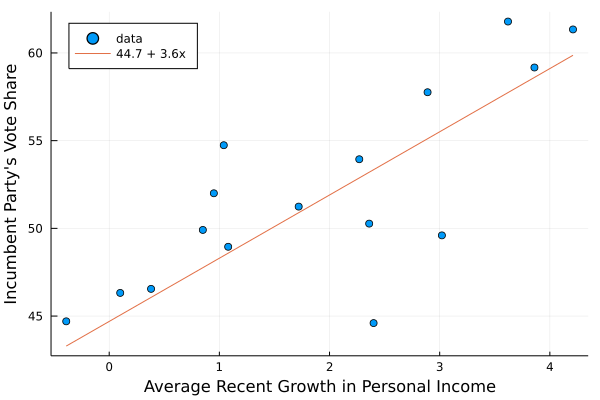

In [7]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="Average Recent Growth in Personal Income",
    ylabel="Incumbent Party's Vote Share",
    label="data"
)

int = mean(results.α)
slope = mean(results.β)
plot!( 
    (x) -> int + slope * x,
    minimum(hibbs[:,:growth]), maximum(hibbs[:,:growth]),
    label= string(round(int,digits=2), " + ", round(slope,digits=2), "x"),
    legend=:topleft
)

## Plot Prediction Given 2% Growth

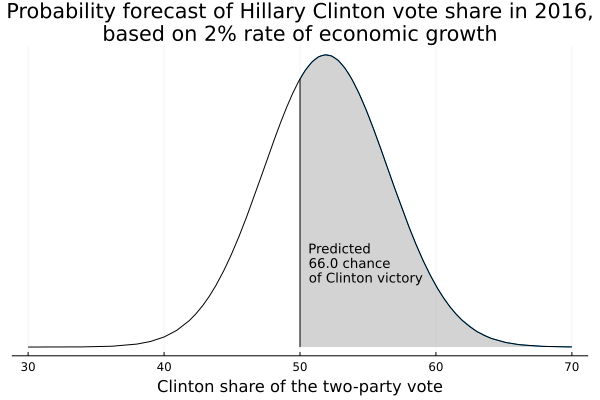

In [8]:
pred_mu = int + slope * 2.0
pred_sigma = sqrt(mean(results.σ))
victory = round( 100*(cdf(Normal(pred_mu, pred_sigma), Inf) - cdf(Normal(pred_mu, pred_sigma), 50)))

title="Probability forecast of Hillary Clinton vote share in 2016,\nbased on 2% rate of economic growth"
xlabel="Clinton share of the two-party vote"
let n = Normal(pred_mu,pred_sigma), (from,x0,to) = (30,50,70)
    plot(x->pdf(n,x), x0, to, fillrange=0, fill=(0,0.5,"darkgray"),
        legend=false, yaxis=false, yticks=false,
        title=title, xlabel=xlabel
    )
    plot!(x->pdf(n,x), from, to, c="black")
    plot!([x0,x0], [0, pdf(n,x0)], c="black")
    annotate!(50.7, 0.025, text("Predicted\n$victory chance\nof Clinton victory",9, :left))
end


## Plot Data and Linear Fit

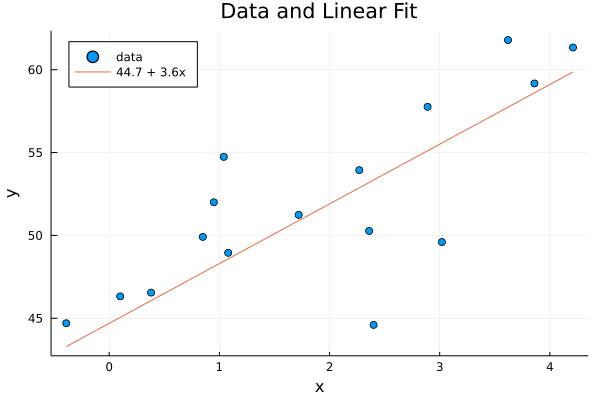

In [9]:
@df hibbs scatter(
    :growth,
    :vote,
    xlabel="x",
    ylabel="y",
    label="data",
    title="Data and Linear Fit"
)
plot!( 
    (x) -> int + slope * x,
    minimum(hibbs[:,:growth]), maximum(hibbs[:,:growth]),
    label= string(round(int,digits=2), " + ", round(slope,digits=2), "x"),
    legend=:topleft
)

## Plot data and a range of possible linear fits

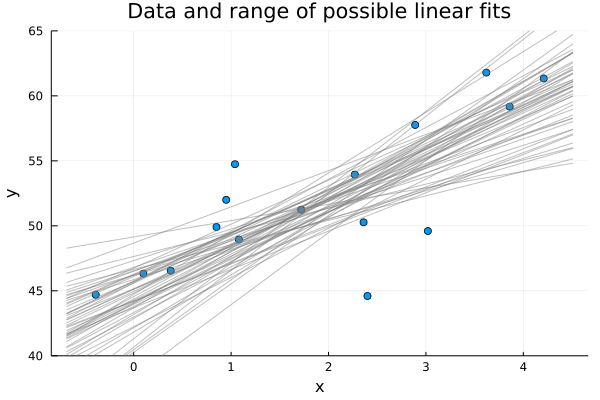

In [10]:
p = @df hibbs scatter(
    :growth,
    :vote,
    xlabel="x",
    ylabel="y",
    label="data",
    title="Data and range of possible linear fits",
    legend=false,
    ylims=(40,65),
)

for i in rand(1:length(results.α), 50)
    plot!( 
        (x) -> results.α[i] + results.β[i] * x,
        minimum(hibbs[:,:growth])-.3, maximum(hibbs[:,:growth])+.3,
        c="gray50", linealpha=0.5
    )
end
display(p)

## Point prediction given 2% growth

In [11]:
predict(model, chain)

DivideError: DivideError: integer division error

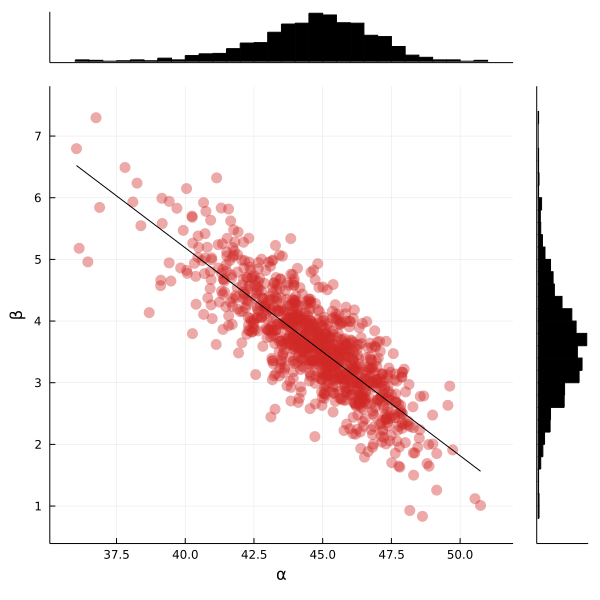

In [26]:
corner(chain, [:α, :β])

### Comparison to `lm()`

In [10]:
using GLM

In [11]:
results_lm = lm(@formula(vote ~ growth), hibbs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

vote ~ 1 + growth

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  46.2476     1.62193   28.51    <1e-13   42.769     49.7263
growth        3.06053    0.696274   4.40    0.0006    1.56717    4.55389
────────────────────────────────────────────────────────────────────────